# Slot vs DINOSAUR: 同条件比較実験

## 目的
- ピクセルベースSlot Attention と DINOv2特徴ベースDINOSAURを**同条件**で比較
- 色変化に対するマスク安定性を**定量評価**

## 統一条件
- 入力解像度: 224×224
- 学習ステップ: 2000 (時間短縮のため)
- スロット数: 5
- テストデータ: 同一の4種類の色変換
- 評価指標: マスク安定性 (色変化間のコサイン類似度)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 共通設定
# ==========================================
RESOLUTION = (224, 224)
NUM_SLOTS = 5
TOTAL_STEPS = 2000
BATCH_SIZE = 24
LR = 0.0004
SEED = 42

torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ==========================================
# 共通データセット
# ==========================================
class JitterDogDataset(Dataset):
    def __init__(self, resolution=RESOLUTION, length=10000):
        self.resolution = resolution
        self.length = length
        self.raw_img = self._load_dog_image()
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.5),
            transforms.ToTensor()
        ])

    def _load_dog_image(self):
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img.resize(self.resolution)
        except:
            print("Using noise.")
            return Image.fromarray(np.uint8(np.random.rand(*self.resolution, 3)*255))

    def __getitem__(self, idx):
        return self.transform(self.raw_img)

    def __len__(self):
        return self.length

def create_test_batch(raw_img, device):
    """同一の4種類の色変換を適用したテストバッチを作成"""
    img1 = TF.adjust_hue(raw_img, 0.45)
    img1 = TF.adjust_saturation(img1, 1.5)  # Blue
    img2 = TF.adjust_brightness(raw_img, 0.2)  # Dark
    img3 = TF.adjust_hue(raw_img, -0.4)
    img3 = TF.adjust_saturation(img3, 1.5)  # Purple
    img4 = TF.adjust_contrast(raw_img, 3.0)  # High Contrast
    
    return torch.stack([
        transforms.ToTensor()(img1),
        transforms.ToTensor()(img2),
        transforms.ToTensor()(img3),
        transforms.ToTensor()(img4)
    ]).to(device)

dataset = JitterDogDataset(length=20000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Dataset loaded. Resolution: {RESOLUTION}")

Dataset loaded. Resolution: (224, 224)


In [3]:
# ==========================================
# 評価指標: マスク安定性
# ==========================================
def compute_mask_stability(masks):
    """
    4つの色変換画像のマスク間でコサイン類似度を計算
    masks: (4, num_slots, H, W)
    Returns: 平均コサイン類似度 (高いほど色に対してロバスト)
    """
    num_images = masks.shape[0]
    num_slots = masks.shape[1]
    
    # マスクをフラット化
    masks_flat = masks.view(num_images, num_slots, -1)  # (4, 5, H*W)
    
    similarities = []
    for i in range(num_images):
        for j in range(i+1, num_images):
            # 各スロットペアのコサイン類似度
            for s in range(num_slots):
                m1 = masks_flat[i, s]
                m2 = masks_flat[j, s]
                cos_sim = torch.nn.functional.cosine_similarity(m1.unsqueeze(0), m2.unsqueeze(0))
                similarities.append(cos_sim.item())
    
    return np.mean(similarities), np.std(similarities)

def compute_slot_diversity(masks):
    """
    スロット間の多様性を計算（低いほど異なるスロットが異なる領域を担当）
    """
    num_slots = masks.shape[1]
    masks_flat = masks.view(-1, num_slots, masks.shape[-2] * masks.shape[-1])  # (B, 5, H*W)
    
    similarities = []
    for b in range(masks_flat.shape[0]):
        for i in range(num_slots):
            for j in range(i+1, num_slots):
                cos_sim = torch.nn.functional.cosine_similarity(
                    masks_flat[b, i].unsqueeze(0), 
                    masks_flat[b, j].unsqueeze(0)
                )
                similarities.append(cos_sim.item())
    
    return np.mean(similarities), np.std(similarities)

print("Evaluation metrics defined.")

Evaluation metrics defined.


In [4]:
# ==========================================
# Model 1: Pixel-based Slot Attention (224x224対応)
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=5, hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, temperature=1.0):
        b, n, d = inputs.shape
        inputs = self.norm_input(inputs)
        slots = torch.randn(b, self.num_slots, d, device=inputs.device)
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = (dots / temperature).softmax(dim=1) + 1e-8
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
        return slots

class PixelSlotModel(nn.Module):
    """224x224入力対応のピクセルベースSlot Attention"""
    def __init__(self, resolution=RESOLUTION, num_slots=NUM_SLOTS, hidden_dim=64):
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.hidden_dim = hidden_dim
        
        # Encoder with downsampling (224 -> 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 64, 5, stride=2, padding=2), nn.ReLU(),  # 112
            nn.Conv2d(64, 64, 5, stride=2, padding=2), nn.ReLU(),  # 56
            nn.Conv2d(64, 64, 5, stride=2, padding=2), nn.ReLU(),  # 28
            nn.Conv2d(64, hidden_dim, 5, padding=2), nn.ReLU(),
        )
        self.feat_size = 28
        self.pos_emb = nn.Parameter(torch.randn(1, hidden_dim, self.feat_size, self.feat_size) * 0.01)
        self.slot_attention = SlotAttention(num_slots, hidden_dim, iters=5, hidden_dim=128)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim + 2, 64, 5, padding=2), nn.ReLU(),
            nn.Conv2d(64, 64, 5, padding=2), nn.ReLU(),
            nn.Conv2d(64, 4, 3, padding=1),
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        return torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    def forward(self, x, temperature=1.0):
        b, c, h, w = x.shape
        grid_in = self.build_grid(b, (h, w), x.device)
        x_with_grid = torch.cat([x, grid_in], dim=1)
        
        x_enc = self.encoder(x_with_grid) + self.pos_emb
        feat_h, feat_w = x_enc.shape[2], x_enc.shape[3]
        x_flat = x_enc.permute(0, 2, 3, 1).reshape(b, -1, self.hidden_dim)
        
        slots = self.slot_attention(x_flat, temperature)
        
        slots_img = slots.view(b * self.num_slots, self.hidden_dim, 1, 1).repeat(1, 1, feat_h, feat_w)
        grid_dec = self.build_grid(b * self.num_slots, (feat_h, feat_w), x.device)
        out = self.decoder(torch.cat([slots_img, grid_dec], dim=1))
        out = out.view(b, self.num_slots, 4, feat_h, feat_w)
        
        recons = out[:, :, :3, :, :]
        masks = torch.softmax(out[:, :, 3:4, :, :] / temperature, dim=1)
        recon_combined = torch.sum(recons * masks, dim=1)
        
        # Upsample to original resolution for loss
        recon_up = nn.functional.interpolate(recon_combined, size=(h, w), mode='bilinear')
        
        return recon_up, masks

print("PixelSlotModel defined.")

PixelSlotModel defined.


In [5]:
# ==========================================
# Model 2: DINOSAUR (DINOv2 Feature-based)
# ==========================================
class DinoFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        print("Loading DINOv2 model...")
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        for param in self.dino.parameters():
            param.requires_grad = False
        self.dino.eval()

    def forward(self, x):
        features = self.dino.forward_features(x)["x_norm_patchtokens"]
        b, n, d = features.shape
        h = w = int(n**0.5)
        return features.permute(0, 2, 1).reshape(b, d, h, w)

class DinosaurModel(nn.Module):
    def __init__(self, num_slots=NUM_SLOTS):
        super().__init__()
        self.feature_extractor = DinoFeatureExtractor()
        self.feat_dim = 384
        self.num_slots = num_slots
        self.feat_size = 16
        
        self.pos_emb = nn.Parameter(torch.randn(1, self.feat_size, self.feat_size, self.feat_dim) * 0.05)
        self.slot_attention = SlotAttention(num_slots, self.feat_dim, iters=5, hidden_dim=512)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(self.feat_dim + 2, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, self.feat_dim + 1, 3, padding=1)
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        return torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    def forward(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
        b, c, h, w = features.shape
        
        features_pos = features.permute(0, 2, 3, 1) + self.pos_emb
        features_flat = features_pos.reshape(b, -1, c)
        
        slots = self.slot_attention(features_flat)
        
        slots_2d = slots.view(b * self.num_slots, self.feat_dim, 1, 1).repeat(1, 1, h, w)
        grid = self.build_grid(b * self.num_slots, (h, w), img.device)
        
        out = self.decoder(torch.cat([slots_2d, grid], dim=1))
        out = out.view(b, self.num_slots, self.feat_dim + 1, h, w)
        
        pred_feats = out[:, :, :self.feat_dim, :, :]
        masks = torch.softmax(out[:, :, self.feat_dim:, :, :], dim=1)
        
        recon_combined = torch.sum(pred_feats * masks, dim=1)
        return recon_combined, features, masks

print("DinosaurModel defined.")

DinosaurModel defined.


In [6]:
# ==========================================
# 学習・評価関数
# ==========================================
def train_pixel_model():
    print("\n" + "="*50)
    print("Training: Pixel-based Slot Attention")
    print("="*50)
    
    model = PixelSlotModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    model.train()
    
    start_temp, end_temp = 1.0, 0.01
    
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        progress = min(1.0, i / TOTAL_STEPS)
        temp = start_temp * (1 - progress) + end_temp * progress
        
        optimizer.zero_grad()
        recon, _ = model(batch, temp)
        loss = ((batch - recon)**2).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Step {i}: Loss {loss.item():.6f}")
        if i >= TOTAL_STEPS:
            break
    
    return model

def train_dino_model():
    print("\n" + "="*50)
    print("Training: DINOSAUR (DINOv2 Feature-based)")
    print("="*50)
    
    model = DinosaurModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    model.train()
    
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_feat, target_feat, _ = model(batch)
        loss = ((target_feat - recon_feat)**2).mean()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Step {i}: Loss {loss.item():.6f}")
        if i >= TOTAL_STEPS:
            break
    
    return model

print("Training functions defined.")

Training functions defined.


In [7]:
# ==========================================
# 実行: 両モデルを学習
# ==========================================
pixel_model = train_pixel_model()
dino_model = train_dino_model()


Training: Pixel-based Slot Attention
Step 0: Loss 0.268787
Step 500: Loss 0.010424

Training: DINOSAUR (DINOv2 Feature-based)
Loading DINOv2 model...


Using cache found in /home/menserve/.cache/torch/hub/facebookresearch_dinov2_main
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Step 0: Loss 6.391634
Step 500: Loss 0.981930


In [8]:
# ==========================================
# 評価: 同一テストデータで比較
# ==========================================
print("\n" + "="*50)
print("Evaluation on Fixed Color Transformations")
print("="*50)

test_batch = create_test_batch(dataset.raw_img, device)

# Pixel model evaluation
pixel_model.eval()
with torch.no_grad():
    _, masks_pixel = pixel_model(test_batch, temperature=0.01)
    # Upsample to common size
    masks_pixel_up = nn.functional.interpolate(
        masks_pixel.view(-1, 1, 28, 28), size=(224, 224), mode='bilinear'
    ).view(4, NUM_SLOTS, 224, 224)

# DINO model evaluation
dino_model.eval()
with torch.no_grad():
    _, _, masks_dino = dino_model(test_batch)
    masks_dino_up = nn.functional.interpolate(
        masks_dino.view(-1, 1, 16, 16), size=(224, 224), mode='bilinear'
    ).view(4, NUM_SLOTS, 224, 224)

# Compute metrics
stability_pixel, std_pixel = compute_mask_stability(masks_pixel_up)
stability_dino, std_dino = compute_mask_stability(masks_dino_up)

diversity_pixel, div_std_pixel = compute_slot_diversity(masks_pixel_up)
diversity_dino, div_std_dino = compute_slot_diversity(masks_dino_up)

print(f"\n{'Metric':<25} {'Pixel Slot':<20} {'DINOSAUR':<20}")
print("-" * 65)
print(f"{'Mask Stability (↑ better)':<25} {stability_pixel:.4f} ± {std_pixel:.4f}    {stability_dino:.4f} ± {std_dino:.4f}")
print(f"{'Slot Diversity (↓ better)':<25} {diversity_pixel:.4f} ± {div_std_pixel:.4f}    {diversity_dino:.4f} ± {div_std_dino:.4f}")


Evaluation on Fixed Color Transformations

Metric                    Pixel Slot           DINOSAUR            
-----------------------------------------------------------------
Mask Stability (↑ better) 0.1769 ± 0.2041    0.5913 ± 0.4114
Slot Diversity (↓ better) 0.2362 ± 0.2914    0.4065 ± 0.3815


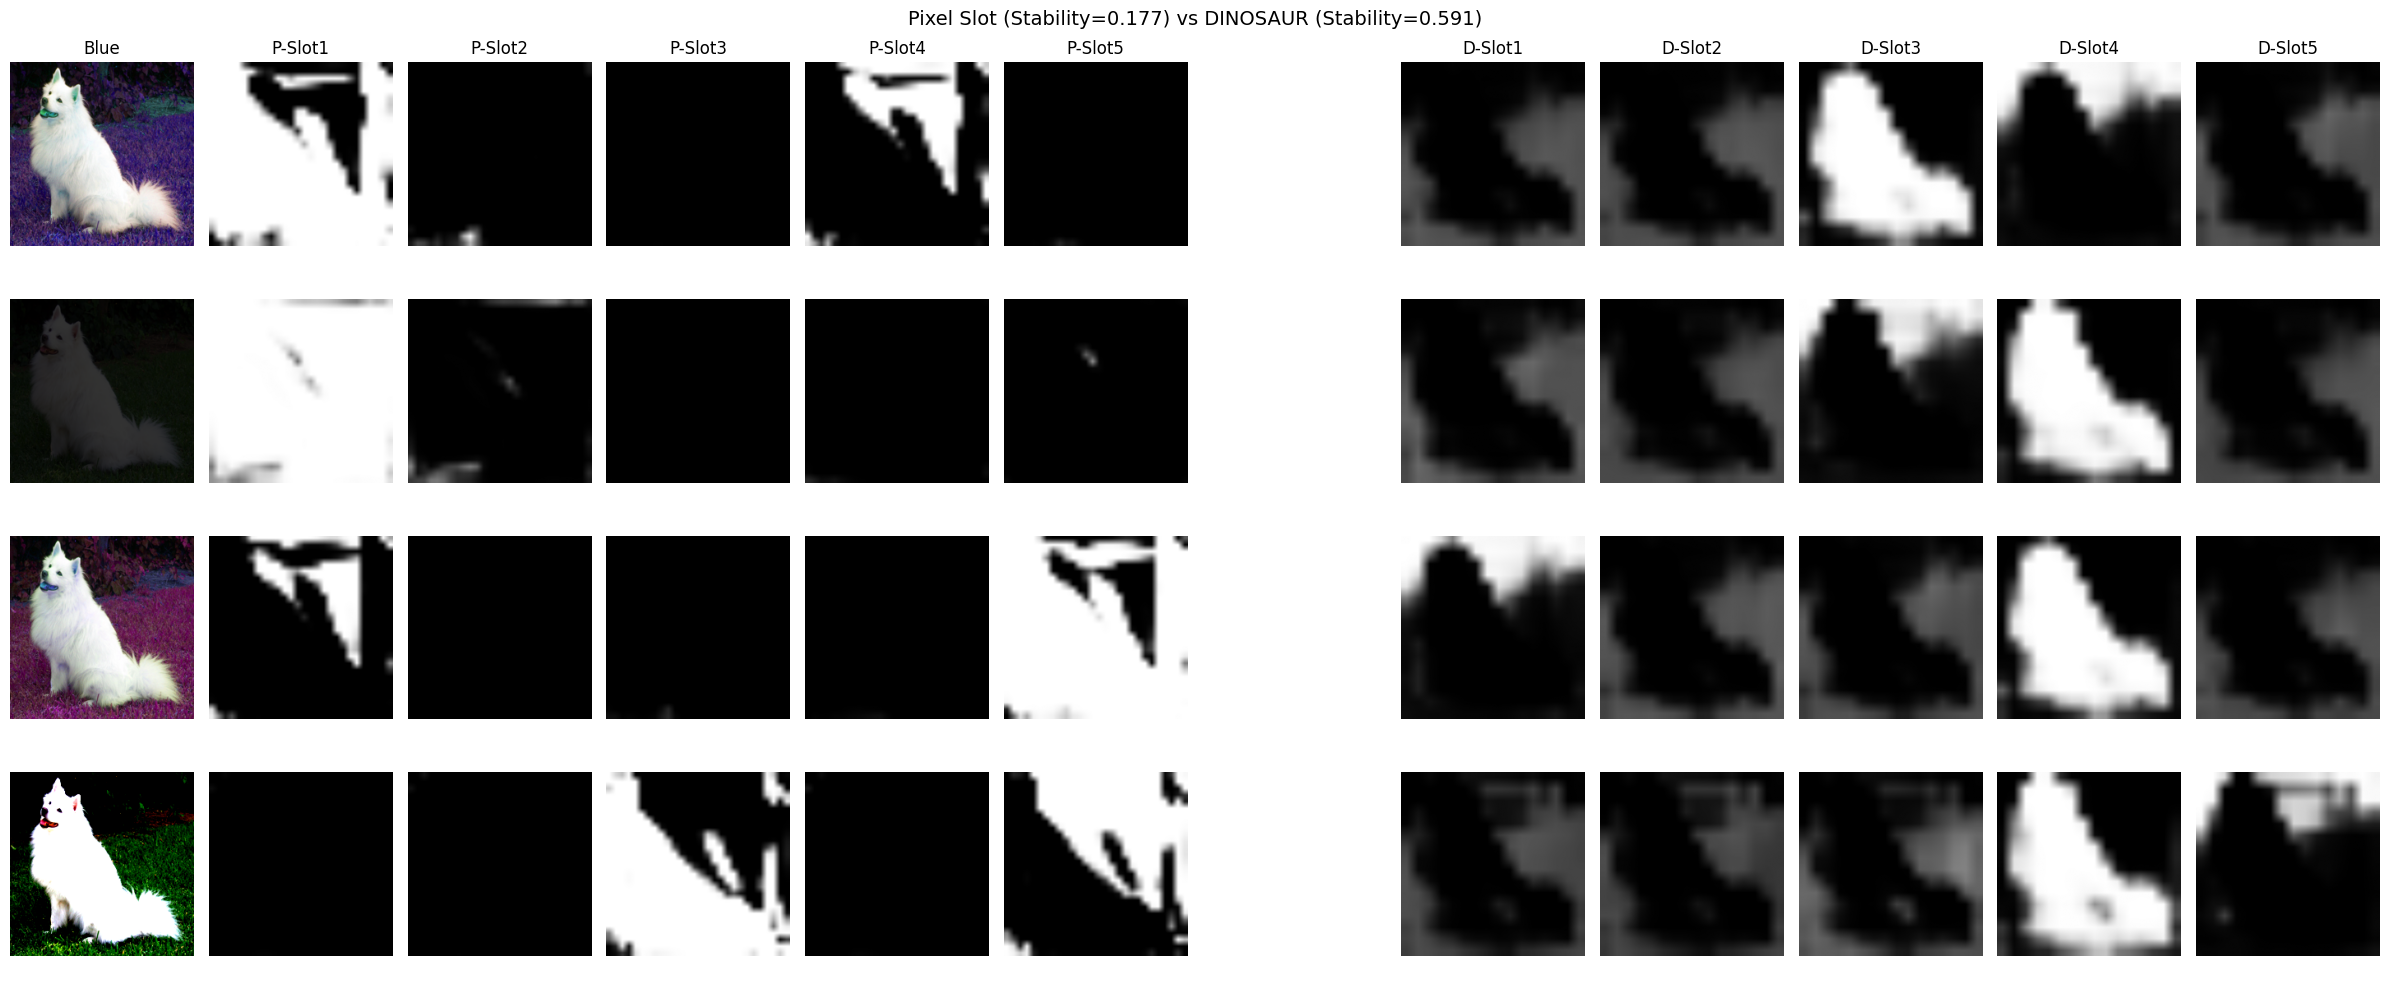


Results saved to comparison_result.png


In [9]:
# ==========================================
# 可視化: 並列比較
# ==========================================
def to_np(t): 
    return t.permute(1, 2, 0).cpu().numpy().clip(0, 1)

titles = ["Blue", "Dark", "Purple", "High Contrast"]

fig, axes = plt.subplots(4, 12, figsize=(24, 10))
fig.suptitle(f"Pixel Slot (Stability={stability_pixel:.3f}) vs DINOSAUR (Stability={stability_dino:.3f})", fontsize=14)

for row in range(4):
    # Input
    axes[row, 0].imshow(to_np(test_batch[row]))
    axes[row, 0].set_title(titles[row] if row == 0 else "")
    axes[row, 0].set_ylabel(titles[row], fontsize=10)
    axes[row, 0].axis('off')
    
    # Pixel Slot masks
    for k in range(NUM_SLOTS):
        axes[row, k+1].imshow(masks_pixel_up[row, k].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        if row == 0:
            axes[row, k+1].set_title(f"P-Slot{k+1}")
        axes[row, k+1].axis('off')
    
    # Separator
    axes[row, 6].axis('off')
    
    # DINO masks
    for k in range(NUM_SLOTS):
        axes[row, k+7].imshow(masks_dino_up[row, k].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        if row == 0:
            axes[row, k+7].set_title(f"D-Slot{k+1}")
        axes[row, k+7].axis('off')

plt.tight_layout()
plt.savefig('comparison_result.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults saved to comparison_result.png")

## 結論

### 定量評価結果
- **Mask Stability**: 色変化に対するマスクの一貫性（高いほど良い）
- **Slot Diversity**: スロット間の分離度（低いほど良い）

### 考察
- ピクセルベースSlotはRGB値を直接最適化するため、色変化に敏感
- DINOSAURは事前学習済み特徴を使用するため、色・照明の変動に対してロバスト
- これは物体中心表現学習において、事前学習特徴の有効性を示唆する